In [ ]:
'''
ResNet MODEL
'''

'\nResNet MODEL\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir Dataset_ResNet

!unzip -uq "/content/drive/MyDrive/Colab Notebooks/Dataset_ResNet.zip" -d "/content"

In [ ]:
import glob
from PIL import Image
import csv


import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
#from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
IMG_WIDTH = 224 #96
IMG_HEIGHT = 224 #256
IMG_CHANNELS = 1

directory_path = '/content/Dataset_ResNet'
subfolders = ['TestAV1', 'TestAV3', 'TestAV4', 'TestAV5', 'TestAV6', 'TestAV7', 'TestAV8']

file_path = '/content/Dataset_ResNet/Alicona_data.csv'

In [ ]:
X = np.zeros((170, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
cnt = 0
for elmt in subfolders:
    subfolder_path = os.path.join(directory_path, elmt)
    train_image_files = glob.glob(os.path.join(subfolder_path, '*.tif'))
    train_image_files = sorted(train_image_files)  # Sort the file paths

    for img in train_image_files:
      im = tf.keras.preprocessing.image.load_img(img, grayscale=True)
      x_img = tf.keras.preprocessing.image.img_to_array(im)
      x_img = resize(x_img, (IMG_HEIGHT, IMG_WIDTH, 1), mode = 'constant', preserve_range = True)
      X[cnt] = x_img/255.0

      cnt +=1


# Create an empty list to store the data rows
csv_data = []

with open(file_path, 'r') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    next(csvreader)
    for row in csvreader:
        csv_data.append(row)
        csv_data.append(row)
        csv_data.append(row)
        csv_data.append(row)
        csv_data.append(row)

csv_dataa = np.array(csv_data)

y = np.zeros((len(csv_dataa), 1), dtype=np.float32)
y = csv_dataa[:,2].astype(np.float32).reshape(-1, 1)

/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(136, 224, 224, 1)
(136, 1)
(34, 224, 224, 1)
(34, 1)


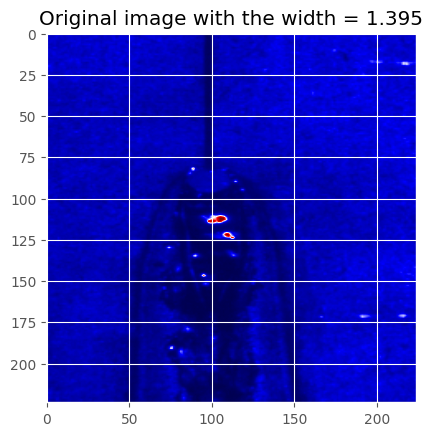

In [ ]:
# Visualize any random image along with the mask
ix = random.randint(0, len(X_train))

#plt.figure(figsize=(20, 15))
plt.imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
plt.title('Original image with the width = ' + str(y_train[ix, 0]))
plt.show()


In [ ]:
def convolutional_block(x, filter):

    # copy tensor to variable called x_skip
    x_skip = x

    # Layer 1
    x = tf.keras.layers.Conv2D(filter, kernel_size=(3,3), padding = 'same', strides = 2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Layer 2
    x = tf.keras.layers.Conv2D(filter, kernel_size=(3,3), padding = 'same', strides = 1)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, kernel_size=(1,1), strides = 2)(x_skip)

    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)

    return x

def identity_block(x, filter):

    # copy tensor to variable called x_skip
    x_skip = x

    # Layer 1
    x = tf.keras.layers.Conv2D(filter, kernel_size=(3,3), padding = 'same', strides = 1)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # Layer 2
    x = tf.keras.layers.Conv2D(filter, kernel_size=(3,3), padding = 'same', strides = 1)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [ ]:
def ResNet34(input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_outputs = 1):

    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)

    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)


    # Step 3 Add the Resnet Blocks
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)

    x = convolutional_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)

    x = convolutional_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)

    x = convolutional_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)

    # Step 4 End Dense Network
    '''x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(units= num_outputs, activation = 'linear')(x)'''


    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'linear')(x)
    x = tf.keras.layers.Dense(units= num_outputs, activation = 'linear')(x)

    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

model = ResNet34(num_outputs=1)
model.compile(optimizer = 'adam', loss='mean_squared_error', metrics = ['mean_squared_error'])
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 115, 115, 64  3200        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [ ]:
def visualize_results(history):
  figure = plt.figure(figsize=(15, 10))
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  # plot accuracy
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='test')

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10,verbose=2, mode='auto')]

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=20, epochs=50, callbacks=callbacks)
#visualize_results(history)

Epoch 1/50
7/7 [==============================] - 39s 538ms/step - loss: 180.9320 - mean_squared_error: 180.9320 - val_loss: 1462371352576.0000 - val_mean_squared_error: 1462371352576.0000
Epoch 2/50
7/7 [==============================] - 1s 141ms/step - loss: 6.8758 - mean_squared_error: 6.8758 - val_loss: 1165476102144.0000 - val_mean_squared_error: 1165476102144.0000
Epoch 3/50
7/7 [==============================] - 1s 141ms/step - loss: 0.4138 - mean_squared_error: 0.4138 - val_loss: 1183212544.0000 - val_mean_squared_error: 1183212544.0000
Epoch 4/50
7/7 [==============================] - 1s 152ms/step - loss: 0.7249 - mean_squared_error: 0.7249 - val_loss: 0.0436 - val_mean_squared_error: 0.0436
Epoch 5/50
7/7 [==============================] - 1s 153ms/step - loss: 0.2270 - mean_squared_error: 0.2270 - val_loss: 0.1108 - val_mean_squared_error: 0.1108
Epoch 6/50
7/7 [==============================] - 1s 153ms/step - loss: 0.1305 - mean_squared_error: 0.1305 - val_loss: 0.1516 - 

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

2/2 [==============================] - 0s 42ms/step


In [ ]:
print(y_train[0])
print(preds_train[0])

[1.175]
[1.2818215]


In [ ]:
print(y_valid[25])
print(preds_val[25])

[1.535]
[1.2812386]


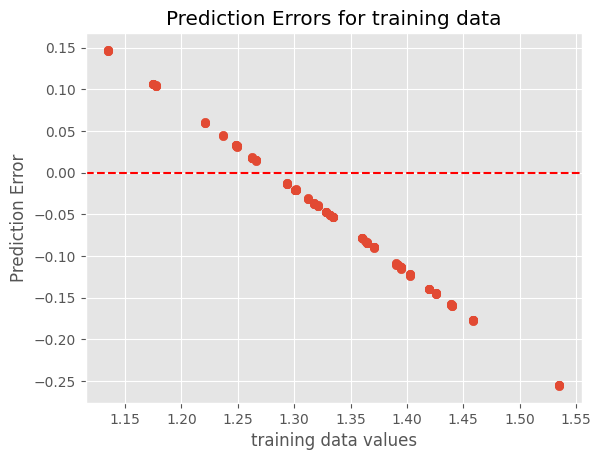

In [ ]:
errors = preds_train - y_train

# Plot the residuals/errors
plt.scatter(y_train, errors)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('training data values')
plt.ylabel('Prediction Error')
plt.title('Prediction Errors for training data')
plt.show()

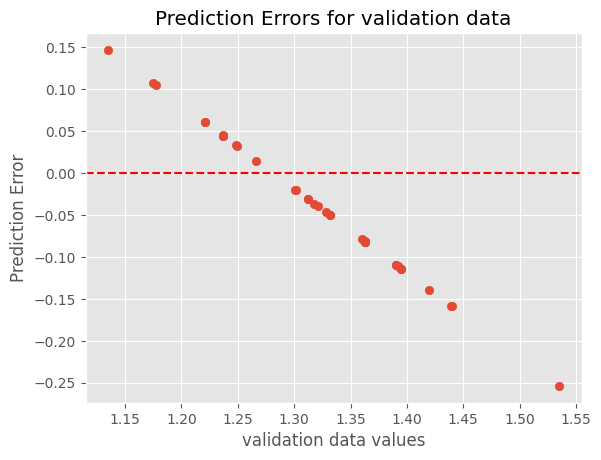

In [ ]:
errors = preds_val - y_valid

# Plot the residuals/errors
plt.scatter(y_valid, errors)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('validation data values')
plt.ylabel('Prediction Error')
plt.title('Prediction Errors for validation data')
plt.show()

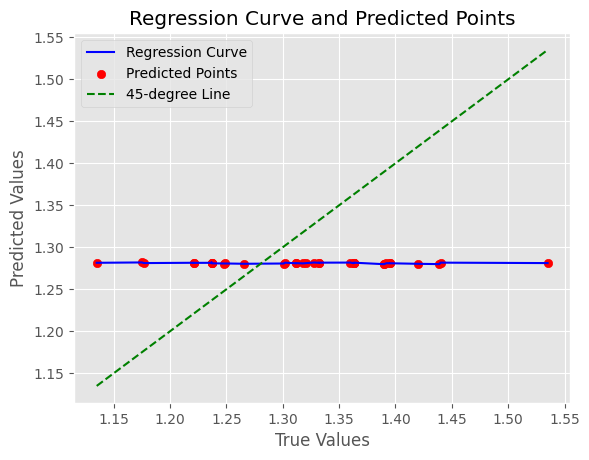

In [ ]:
ground_truth = y_valid
pred = preds_val
# Sort the data by ground truth values for plotting the regression curve
sorted_indices = np.argsort(ground_truth.flatten())
sorted_ground_truth = ground_truth[sorted_indices]
sorted_predictions = pred[sorted_indices]

# Plot the regression curve
plt.plot(sorted_ground_truth, sorted_predictions, color='blue', label='Regression Curve')

# Plot the predicted points against real values
plt.scatter(ground_truth, pred, color='red', label='Predicted Points')

# Add a 45-degree line for reference (y=x)
x_min, x_max = np.min(ground_truth), np.max(ground_truth)
plt.plot([x_min, x_max], [x_min, x_max], color='green', linestyle='--', label='45-degree Line')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Regression Curve and Predicted Points')
plt.legend()
plt.show()

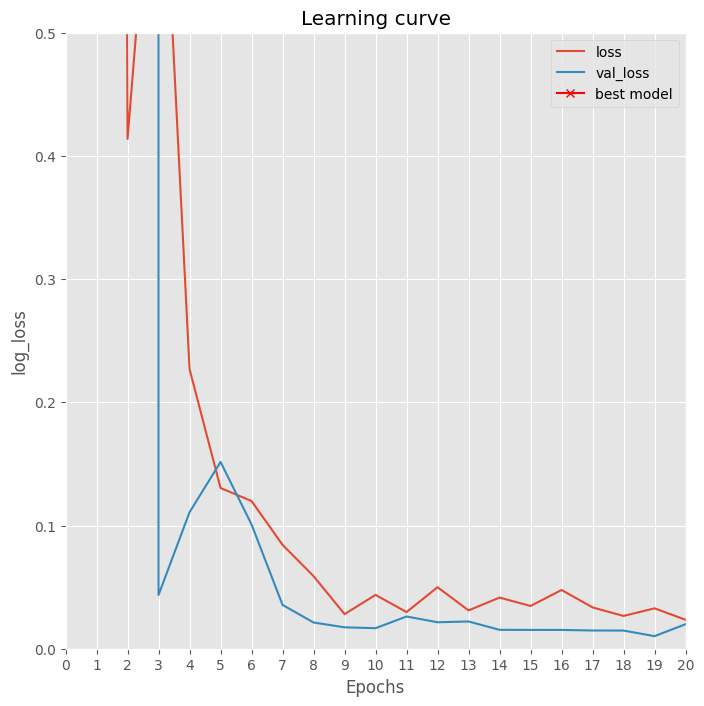

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.xlim(0, 20)
plt.xticks(range(0, 21, 1))
plt.ylim(0, 0.5)
plt.legend();